
   

![title](./img/ds_em_projetos.png)  






# Bem vindos ao evento Data Science em Projetos

## Dia 03 - Predição de Diabetes

No 1o dia do evento vimos aplicação de DS e ML em predição de preços de carros, que pode ser utilizado em diferentes aplicações. Na 2a live criamos outra aplicação bem útil, sistema de recomendações de filmes, que pode ser utilizado para vários tipos de organizações e processos de negócio (varejo, serviços, basicamente tudo que é e-commerce).

Dessa vez é hora de adentrar na utilização de machine learning para auxílio de diagnóstico. Medicina tem utilizado cada vez mais funcionalidades de ML, principalmente na detecção de imagens e no auxílio de diagnóstico a partir de informações laboratoriais e clínicas. Trouxemos um exemplo simples de uso para identificar os riscos do controle de uma doença que afeta milhões de pessoas em todo o mundo: diabetes.

Você pode baixar os dados que vamos utilizar nesse projeto diretamente no [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

De acordo com o Kaggle (tradução livre), "este conjunto de dados é originalmente do Instituto Nacional de Diabetes e Doenças Digestivas e Renais. O objetivo do conjunto de dados é prever o diagnóstico de um paciente se tem diabetes ou não, com base em certas medidas diagnósticas incluídas no conjunto de dados. Várias restrições foram colocadas na seleção dessas instâncias de um banco de dados maior. Em particular, todos os pacientes aqui são mulheres com pelo menos 21 anos de herança indígena Pima."

Essa é uma base bem conhecida e utilizamos para montar uma aplicação Streamlit que faz a previsão com base no modelo treinado.

Salientamos que saúde é uma área muito complexa e a utilização de algoritmos em produção é muito difícil, devendo contar com médicos e especialistas para validação, pois estamos tratando de vidas. Desse modo, não custa salientar que esse notebook **não deve ser utilizado ne predição de diabetes de pacientes reais em produção**. Sintam-se livres para utilizarem outras bases, reais ou não, mas utilizar para definir ou auxiliar o diagnóstico requer uma rigidez acadêmica por conta do risco que erros podem causar à saúde das pessoas.

Dito isso, conhecemos muitos profissionais da área e os algoritmos utilizados são muito similares aos que apresentamos aqui, sendo o diferencial o acesso a pacientes reais e aos médicos especialistas para definição de features e validação do modelo.

Como nosso problema é prever se um paciente tem ou não diabetes, temos uma classificação, pois a variávei dependente é discreta (tem ou não tem diabetes). Nosso intuito é criar uma aplicação para uma clínica ou um laboratório de análises clínicas. É importante para os médicos ter auxílio de ferramentas de ML para prevenir e controlar doenças. 

Assim como estamos fazendo para diabetes, podemos abstrair para outras tantas aplicações de classificação: fraudes em transações bancárias, se um cliente vai continuar na empresa ou não (churn), se um cliente vai pagar os empréstimos ou não (análise de risco de crédito), saber se um empregado vai sair da empresa ou não, etc...

O notebook inicial foi obtido nesse [vídeo](https://www.youtube.com/watch?v=nacLBdyG6jE&list=PLfFghEzKVmjvuSA67LszN1dZ-Dd_pkus6&index=4) com esse [código](https://colab.research.google.com/drive/1oxnhMTlomJ4HVhPuowpPFyMt1mwuOuQo?usp=sharing) Ele está bem básico e acrescentamos o uso de outros algoritmos e cross validation que não estão lá.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

### Carregar a base de dados!

Sempre gosto de criar uma pastinha "data" pra organizar. Utilizamos pandas pra carregar os dados. Se ainda não conhece, a gente tem dois vídeos introdutórios, acesso [aqui](https://www.youtube.com/watch?v=iOjtCIcU3HQ) e [aqui](https://www.youtube.com/watch?v=5Ja_f8Q3IHw) :)

Os dados foram extraídos de um site de vendas indiano chamado [Cardekho](https://www.cardekho.com/)

In [2]:
# Carregando a base para um dataframe pandas
pacientes = pd.read_csv('./data/diabetes.csv') 

In [3]:
# olhar as 1as 5 linhas
pacientes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
pacientes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
# Renomear as colunas para o bom e velho PORTUGA (mas temos que treinar inglês, hein, galera, coloca na lista aí)
pacientes.columns = ['num_gravidez', 
                  'glicose', 
                  'pressao_sanguinea', 
                  'espessura_pele', 
                  'insulina', 
                  'imc', # indice de massa corporal
                  'teste_tolerancia_glicose', 
                  'idade', 
                  'tem_diabetes']
pacientes.head()


,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade,tem_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Numero de linhas e colunas
pacientes.shape

(768, 9)

In [7]:
pacientes['tem_diabetes'].value_counts()

0    500
1    268
Name: tem_diabetes, dtype: int64

In [8]:
# Acuracia base: 'chuta' que não tem diabetes
500/768

0.6510416666666666

In [9]:
# Informacoes basicas das colunas e valores
pacientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num_gravidez              768 non-null    int64  
 1   glicose                   768 non-null    int64  
 2   pressao_sanguinea         768 non-null    int64  
 3   espessura_pele            768 non-null    int64  
 4   insulina                  768 non-null    int64  
 5   imc                       768 non-null    float64
 6   teste_tolerancia_glicose  768 non-null    float64
 7   idade                     768 non-null    int64  
 8   tem_diabetes              768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
# Avaliando valores faltantes
pacientes.isnull().sum()

num_gravidez                0
glicose                     0
pressao_sanguinea           0
espessura_pele              0
insulina                    0
imc                         0
teste_tolerancia_glicose    0
idade                       0
tem_diabetes                0
dtype: int64

### Uma EDA simples pra verificar possíveis correlações e entender melhor a base

In [11]:
pacientes.describe()

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade,tem_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
pacientes['insulina'].describe()

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: insulina, dtype: float64

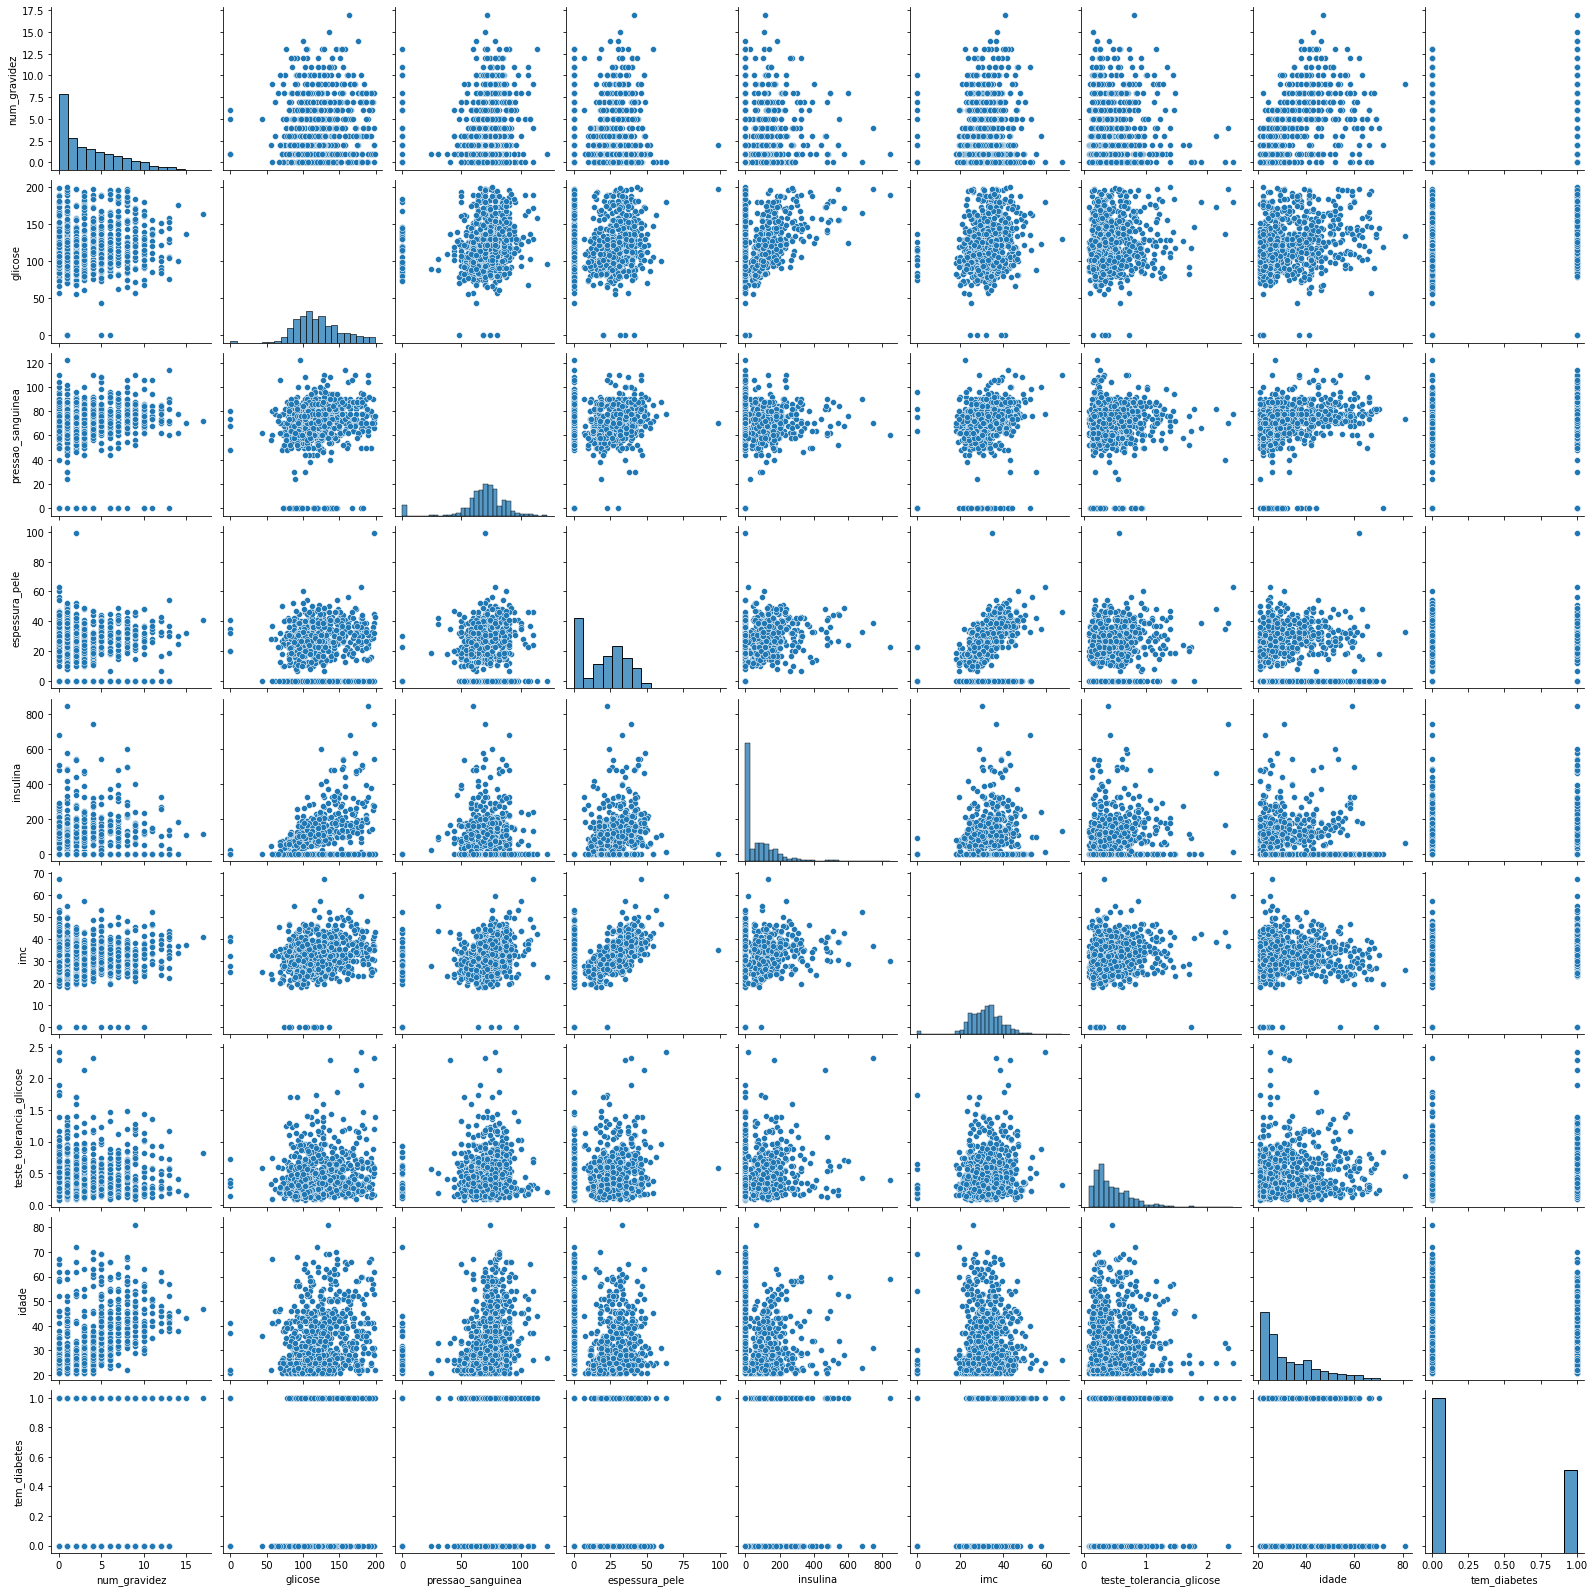

In [13]:
sns.pairplot(pacientes)

### Separando variáveis preditoras e target

In [14]:
X = pacientes.drop(['tem_diabetes'],axis=1)
Y = pacientes['tem_diabetes']

In [15]:
X

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [16]:
Y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: tem_diabetes, Length: 768, dtype: int64

#### Fazendo split (antes de scaling, imputação, codificação de variáveis categóricas!!

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=2)

In [18]:
X_train.shape, X_test.shape

((691, 8), (77, 8))

### Tratamento de outliers, dados faltantes e realizar scaling

**SEMPRE** depois do split

<AxesSubplot:>

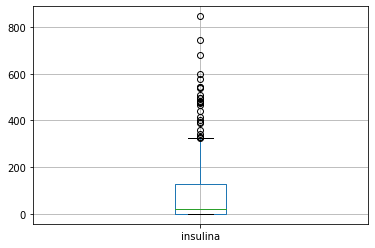

In [19]:
# Remoção de outlier com intervalo interquartil
# Definição: Intervalo Interquartílico -> boxplot pra ajudar
X_train[['insulina']].boxplot()

In [20]:
# IIQ quartil 3 - quartil 1
quartil_1 = X_train['insulina'].describe()['25%']
quartil_3 = X_train['insulina'].describe()['75%']

iiq = quartil_3 - quartil_1

iiq

130.0

In [21]:
# Valores 1,5 IIQ abaixo de Q1 ou mais de 1,5 IIQ acima de Q3 são consideradas outliers.
outlier_pra_baixo = quartil_1 - (1.5 * iiq)
outlier_pra_cima = quartil_3 + (1.5 * iiq)

outlier_pra_baixo, outlier_pra_cima

(-195.0, 325.0)

In [22]:
# Para remover os outliers

X_train_sem_outliers = X_train.loc[(X_train['insulina'] > outlier_pra_baixo) & (X_train['insulina'] < outlier_pra_cima)]
X_train_sem_outliers.shape

(661, 8)

C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='insulina', ylabel='Density'>

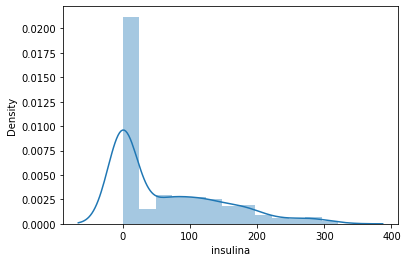

In [23]:
sns.distplot(X_train_sem_outliers['insulina'])

<AxesSubplot:>

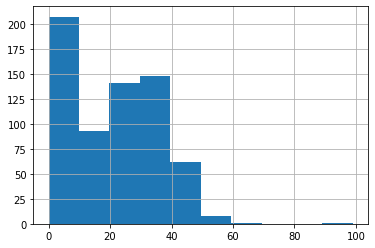

In [24]:
X_train_sem_outliers['espessura_pele'].hist()

In [25]:
len(X_train_sem_outliers.loc[X_train_sem_outliers['espessura_pele'] == 0])

204

In [26]:
media_espessura_NO_TREEEEEINO = X_train_sem_outliers.loc[X_train_sem_outliers['espessura_pele'] > 0, 'espessura_pele'].mean()
media_espessura_NO_TREEEEEINO

28.89496717724289

C:\Users\felip\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:>

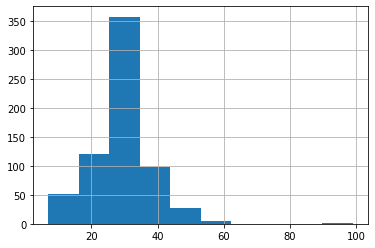

In [27]:
X_train_sem_outliers.loc[X_train_sem_outliers['espessura_pele'] == 0, 'espessura_pele'] = media_espessura_NO_TREEEEEINO
X_train_sem_outliers['espessura_pele'].hist()

<AxesSubplot:>

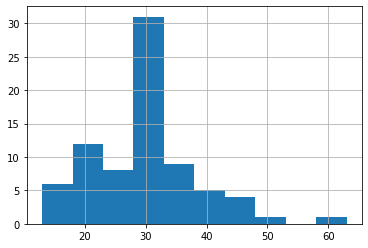

In [28]:
# Agora sim, aplicar no teste
X_test.loc[X_test['espessura_pele'] == 0, 'espessura_pele'] = media_espessura_NO_TREEEEEINO
X_test['espessura_pele'].hist()


In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Treinar os modelos!

1. Support Vector Machines

In [30]:
# Criando objeto de regressao linear
classifier = svm.SVC(kernel='linear')

Validação do modelo com cross validation

In [31]:
# Validacao cruzada com acurácia 
scores_svm = cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv=5)
scores_svm

array([0.73381295, 0.76811594, 0.79710145, 0.76086957, 0.79710145])

In [32]:
scores_svm.mean()

0.7714002710874779

2. Random Forest

In [33]:
# Criando objeto de random forest
rf_classifier = RandomForestClassifier()

In [34]:
# Validacao cruzada com acurácia de métrica
scores_rf = cross_val_score(rf_classifier, X_train, y_train, scoring='accuracy', cv=5)
scores_rf

array([0.76978417, 0.7173913 , 0.73188406, 0.76086957, 0.76086957])

In [35]:
scores_rf.mean()

0.7481597330830988

### Temos o campeao?? Então podemos treinar na base de treino

In [36]:
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Cadê o teste??? Rá, o teste sempre depois de escolher o modelo CAMPEÃO

In [37]:
# Predições na base de teste
predicoes = classifier.predict(X_test)

In [38]:
error_score = accuracy_score(y_test, predicoes)
print("Acurácia : ", error_score)

Acurácia :  0.7792207792207793


### Modelo pronto, validado e testado!!! Hora de "empacotar" pra usar na aplicação

In [39]:
import joblib

with open('./models/classifier.pkl', 'wb') as arquivo_modelo:
    joblib.dump(classifier, arquivo_modelo,compress=3)
    
with open('./models/scaler.pkl', 'wb') as arquivo_modelo:
    joblib.dump(scaler, arquivo_modelo,compress=3)    